<a href="https://colab.research.google.com/github/MagdalenaSkowerska/Finding-Similar-Items-/blob/main/finding_similar_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and the data

In [ ]:
from google.colab import files
files.upload()


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

In [ ]:
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024


In [ ]:
!unzip 1-3m-linkedin-jobs-and-skills-2024.zip

### Install libraries

In [ ]:
!pip install datasketch

In [ ]:
!pip install pyspark

### Import libraries

In [50]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datasketch import MinHash, MinHashLSH
from sklearn.neighbors import NearestNeighbors
import nltk
from nltk.corpus import stopwords
from pyspark.sql import SparkSession, functions as fun
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinHashLSH as MLLSH
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Importing stopwords list and wordnet

In [ ]:
nltk.download('stopwords')

In [52]:
stop_words = stopwords.words('english')
stop_words.append('non')

In [53]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
nltk.download('wordnet')

### Setting up Spark  

In [55]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
sc = spark.sparkContext

### Uploading data from file

In [56]:
job_skills= spark.read.csv("job_skills.csv", header=True, inferSchema=True)
job_summary=spark.read.csv("job_summary.csv", header=True, inferSchema=True, multiLine=True, quote='"', escape='\"')
linkedin_job_postings=spark.read.csv("linkedin_job_postings.csv",header=True, inferSchema=True, multiLine=True)

In [57]:
job_skills.createOrReplaceTempView("job_skills")
job_summary.createOrReplaceTempView("job_summary")
linkedin_job_postings.createOrReplaceTempView("linkedin_job_postings")

# DATA CLEANING AND PREPROCESSING

In [58]:
job_skills.show(10)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
+--------------------+--------------------+
only showing top 10 rows



In [59]:
job_summary.show(10)

+--------------------+--------------------+
|            job_link|         job_summary|
+--------------------+--------------------+
|https://www.linke...|Rock N Roll Sushi...|
|https://www.linke...|Schedule\n: PRN i...|
|https://www.linke...|Description\nIntr...|
|https://uk.linked...|Commercial accoun...|
|https://www.linke...|Address:\nUSA-CT-...|
|https://www.linke...|Description\nOur\...|
|https://www.linke...|Company Descripti...|
|https://uk.linked...|An exciting oppor...|
|https://www.linke...|Job Details:\nJob...|
|https://www.linke...|Our\nRestaurant T...|
+--------------------+--------------------+
only showing top 10 rows



In [60]:
linkedin_job_postings.show(10)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen| search_city|search_country|     search_position| job_level|job_type|
+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+--------------------+----------+--------+
|https://www.linke...|2024-01-21 07:12:...|          t|      t|              f|Account Executive...|                  BD|       San Diego, CA|2024-01-15|    Coronado| United States|         Color Maker|Mid senior|  Onsite|
|https://www.linke...|2024-01-21 07:39:...|          t|      t|              f|Registered Nurse ...|   Trini

### Counting null values

In [61]:
null_count = job_summary.filter(fun.col("job_summary").isNull()).count()
print(f"The number of null values for the job_summary column is: {null_count}")

The number of null values for the job_summary column is: 0


In [62]:
null_count = job_summary.filter(fun.col("job_link").isNull()).count()
print(f"The number of null values for the job_link column is: {null_count}")

The number of null values for the job_link column is: 0


### Counting distinct values

In [63]:
distinct_count = job_summary.select("job_summary").distinct().count()
print(f"The number of distinct job_summary values is: {distinct_count}")

The number of distinct job_summary values is: 958192


In [64]:
distinct_count = job_summary.select("job_link").distinct().count()
print(f"The number of distinct job_link values is: {distinct_count}")

The number of distinct job_link values is: 1297332


In [65]:
rows_number = job_summary.count()
print(f"The total number of rows in the table is: {rows_number}")

The total number of rows in the table is: 1297332


### Number of occurences of the same description jobs

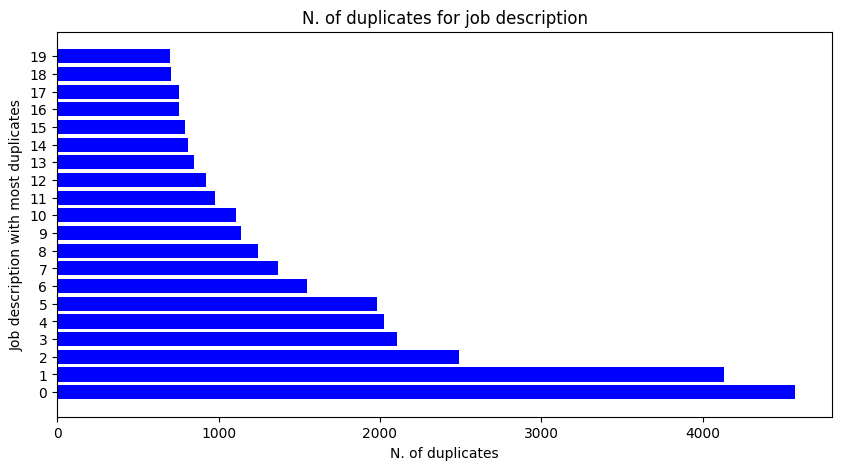

In [66]:
job_counts = job_summary.groupBy("job_summary").count().orderBy("count", ascending=False).limit(20)
job_counts = job_counts.toPandas()
duplicates=job_counts['count']
indexes=job_counts.index.astype(str)

plt.figure(figsize=(10, 5))
plt.barh(indexes, duplicates, color="blue")
plt.xlabel("N. of duplicates")
plt.ylabel("Job description with most duplicates")
plt.title("N. of duplicates for job description")
plt.show()

# Tokenization removing stopwords

In [67]:
def string_tokenization(string):
  """ Tokenize strings in input
  Args:
    string (str): input string
  Returns:
    list: a list of tokens
  """
  return [token for token in re.split(r'\W+', string.lower()) if token and len(token)>2]

In [68]:
def remove_stopwords(token_list):
  """ Remove stopwords from lists in input
  Args:
    token_list (list): input list of strings
  Returns:
    list: a list of tokens
  """
  return [token for token in token_list if token not in stop_words]

In [69]:
def stemmer_lemmatizer_tokens(token_list):
  """ Stem and lemmatize the list in input
  Args:
    token_list (list): input list of strings
  Returns:
    list: a list of tokens
  """
  stemmer = PorterStemmer()
  token_list=[stemmer.stem(word) for word in token_list]

  lemmatizer = WordNetLemmatizer()
  token_list=[lemmatizer.lemmatize(word) for word in token_list]

  return token_list

In [70]:
job_summary_token=job_summary.rdd.map(lambda s: (s[0], string_tokenization(s[1])))

In [71]:
job_summary_token=job_summary_token.map(lambda s: (s[0], remove_stopwords(s[1])))

In [72]:
job_summary_token=job_summary_token.map(lambda s: (s[0], stemmer_lemmatizer_tokens(s[1])))

In [73]:
tokenize_job_description_len=job_summary_token.take(10000)
tokenize_job_description_len=sc.parallelize(tokenize_job_description_len).map(lambda s: len(s[1]))

In [74]:
max_len=tokenize_job_description_len.max()
min_len=tokenize_job_description_len.min()
avg_len=tokenize_job_description_len.mean()
print(f"""The average length of the first 10000 job descriptions is: {avg_len:.4f}
          The min length is: {min_len}
          The max length is: {max_len}""")

The average length of the first 10000 job descriptions is: 412.7496
          The min length is: 13
          The max length is: 2234


In [75]:
sample=job_summary_token.take(10)
sample=sc.parallelize(sample)

In [76]:
print(sample.take(1))

[('https://www.linkedin.com/jobs/view/restaurant-manager-at-rock-n-roll-sushi-3805551344', ['rock', 'roll', 'sushi', 'hire', 'restaur', 'manag', 'restaur', 'manag', 'never', 'bore', 'respons', 'make', 'sure', 'restaur', 'run', 'smoothli', 'offer', 'competit', 'compens', 'insur', 'benefit', 'bonu', 'opportun', 'great', 'work', 'atmospher', 'duti', 'respons', 'ensur', 'restaur', 'fulli', 'appropri', 'staf', 'time', 'maintain', 'oper', 'excel', 'restaur', 'run', 'effici', 'effect', 'ensur', 'law', 'regul', 'guidelin', 'follow', 'creat', 'restaur', 'atmospher', 'patron', 'employe', 'enjoy', 'variou', 'task', 'need', 'requir', 'previou', 'experi', 'restaur', 'manag', 'extens', 'food', 'beverag', 'knowledg', 'abil', 'rememb', 'recal', 'ingredi', 'dish', 'inform', 'custom', 'wait', 'staff', 'great', 'leadership', 'skill', 'familiar', 'restaur', 'manag', 'softwar', 'demonstr', 'abil', 'coordin', 'staff', 'show', 'show', 'less'])]


# TF-IDF

In [77]:
def tf(tokens):
  """ Compute TF
    Args:
        tokens (list of str): input list of strings
    Returns:
        dictionary: a dictionary of tokens to its TF values
"""
  val = {}

  for t in tokens:
    if t in val:
      val[t] += 1
    else:
      val[t] = 1.0

  for t in val:
    val[t] /= len(tokens)

  return val

In [78]:
def idfs(corpus):
    """ Compute IDF
      Args:
          corpus (RDD): input RDD of documents represented by job link and description
      Returns:
          dictionary: dictionary of tokens to IDF values
    """

    unique_tokens = corpus.flatMap(lambda doc: doc[1]).distinct().collect()
    N = corpus.count()
    idfs_val = {token: 0 for token in unique_tokens}

    for token in unique_tokens:
        doc_freq = corpus.filter(lambda doc: token in doc[1]).count()
        if doc_freq > 0:
          idfs_val[token] = N / doc_freq
        else:
          0

    return idfs_val

In [79]:
def tfidf(tokens, idfs):
  """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): a dictionary of tokens to IDF values
    Returns:
        dictionary: a dictionary of tokens to TF-IDF values
  """
  tf_tokens=tf(tokens)
  tf_idf_dict = {t: tf_tokens[t]*idfs[t] for t in tokens}

  return tf_idf_dict


In [80]:
def idfs_optimized(corpus):
    """ Compute IDF
      Args:
          corpus (RDD): input RDD of documents represented by job link and description
      Returns:
          RDD: RDD of tokens to IDF values
    """

    unique_tokens = corpus.flatMap(lambda doc: doc[1]).distinct().collect()
    N = corpus.count()

    token_doc_pairs = corpus.flatMap(lambda doc: [(token, doc[0]) for token in set(doc[1])])
    doc_freq_optimized = token_doc_pairs.map(lambda pair: (pair[0], 1)).reduceByKey(lambda a, b: a + b)
    idfs_val = doc_freq_optimized.map(lambda token_freq_record: (token_freq_record[0], N / token_freq_record[1] if token_freq_record[1] > 0 else 0))

    return idfs_val

In [81]:
def tfidf_optimized(corpus, idfs):
    """ Compute TF-IDF
    Args:
        corpus (RDD): RDD contatining all documents represented by a list of tokens
        idfs (RDD): RDD of tokens to IDF values
    Returns:
        RDD: RDD of elements of the form (document ID, {token: TF-IDF value , ...})
    """

    doc_tf_dict_rdd = corpus.map(lambda doc: (doc[0], tf(doc[1])))
    token_tf_doc = doc_tf_dict_rdd.flatMap(lambda doc_tf_dict: [( token, (tf_value, doc_tf_dict[0])) for token, tf_value in doc_tf_dict[1].items()])

    # x of the type (token, ((tf_value, document ID), idf_value))
    doc_token_tf_idf_rdd = token_tf_doc.join(idfs).map(lambda x: (x[1][0][1], x[0], x[1][0][0] * x[1][1]))
    doc_tf_idf_dict_rdd = doc_token_tf_idf_rdd.map(lambda x: (x[0], {x[1]: x[2]})).reduceByKey(lambda a, b: {**a, **b})

    return doc_tf_idf_dict_rdd

## Applying TF-IDF to a sample of data made of 10 records

In [82]:
corpus_sample = sample

In [83]:
idfs_val=idfs(corpus_sample)

In [84]:
tfidf_rdd = corpus_sample.map(lambda doc: (doc[0], tfidf(doc[1], idfs_val)))

tfidf_first=tfidf_rdd.take(1)
print(tfidf_first)
# tfidf_list = tfidf_rdd.collect()
# for link, tfidf_values in tfidf_list:
#     print(f"{link}:\n {tfidf_values}")

[('https://www.linkedin.com/jobs/view/restaurant-manager-at-rock-n-roll-sushi-3805551344', {'rock': 0.11494252873563218, 'roll': 0.11494252873563218, 'sushi': 0.11494252873563218, 'hire': 0.05747126436781609, 'restaur': 0.30651340996168586, 'manag': 0.05747126436781609, 'never': 0.11494252873563218, 'bore': 0.11494252873563218, 'respons': 0.03831417624521073, 'make': 0.014367816091954023, 'sure': 0.11494252873563218, 'run': 0.22988505747126436, 'smoothli': 0.11494252873563218, 'offer': 0.022988505747126436, 'competit': 0.03831417624521073, 'compens': 0.11494252873563218, 'insur': 0.022988505747126436, 'benefit': 0.022988505747126436, 'bonu': 0.03831417624521073, 'opportun': 0.014367816091954023, 'great': 0.11494252873563218, 'work': 0.01277139208173691, 'atmospher': 0.11494252873563218, 'duti': 0.05747126436781609, 'ensur': 0.03831417624521073, 'fulli': 0.11494252873563218, 'appropri': 0.05747126436781609, 'staf': 0.05747126436781609, 'time': 0.014367816091954023, 'maintain': 0.0164203

### TF-IDF optimized for distributed systems

In [85]:
idfs_val_optimized=idfs_optimized(corpus_sample)

In [86]:
tfidf_rdd_optimized = tfidf_optimized(corpus_sample, idfs_val_optimized)

In [87]:
print(idfs_val_optimized.take(10))

[('leadership', 2.5), ('staf', 5.0), ('atmospher', 5.0), ('creat', 5.0), ('oper', 1.6666666666666667), ('employe', 1.4285714285714286), ('effect', 1.6666666666666667), ('variou', 10.0), ('softwar', 10.0), ('task', 10.0)]


In [88]:
tfidf_optimized_first=tfidf_rdd_optimized.take(1)
print(tfidf_optimized_first)
# for item in tfidf_rdd_optimized.toLocalIterator():
#     print(f"{item[0]}:\n {item[1]}")

[('https://www.linkedin.com/jobs/view/store-manager-at-stop-shop-3782135496', {'work': 0.004273504273504274, 'ensur': 0.006410256410256411, 'creat': 0.038461538461538464, 'leadership': 0.028846153846153848, 'job': 0.005494505494505495, 'team': 0.012820512820512822, 'provid': 0.009615384615384616, 'condit': 0.009615384615384616, 'perform': 0.007692307692307693, 'diver': 0.019230769230769232, 'color': 0.007692307692307693, 'environ': 0.005494505494505495, 'posit': 0.01098901098901099, 'includ': 0.057692307692307696, 'ident': 0.019230769230769232, 'peopl': 0.007692307692307693, 'possibl': 0.009615384615384616, 'nation': 0.009615384615384616, 'origin': 0.007692307692307693, 'gender': 0.019230769230769232, 'orient': 0.019230769230769232, 'busi': 0.012820512820512822, 'sale': 0.012820512820512822, 'record': 0.009615384615384616, 'interperson': 0.019230769230769232, 'best': 0.009615384615384616, 'road': 0.038461538461538464, 'store': 0.057692307692307696, 'human': 0.019230769230769232, 'brand

### TF-IDF with sklearn

In [89]:
job_sum_col_sample=job_summary.select('job_summary').limit(10).collect()
job_sum_col_sample_list=[row[0] for row in job_sum_col_sample]

In [90]:
job_link_col_sample=job_summary.select('job_link').limit(10).collect()
job_link_col_sample_list=[row[0] for row in job_link_col_sample]

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=string_tokenization)
tfidf_matrix = vectorizer.fit_transform(job_sum_col_sample_list)

In [92]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=job_link_col_sample_list, columns=vectorizer.get_feature_names_out())

# Applying TF-IDF to a bigger dataset

In [93]:
corpus = job_summary_token.take(1000)
corpus=sc.parallelize(corpus)

### TF-IDF optimized for distributed systems



In [94]:
idfs_val_optimized=idfs_optimized(corpus)

In [95]:
tfidf_rdd_optimized = tfidf_optimized(corpus, idfs_val_optimized)

tfidf_optimized_first= tfidf_rdd_optimized.first()
print(tfidf_optimized_first)
# for item in tfidf_rdd_optimized.toLocalIterator():
#     print(f"{item[0]}:\n {item[1]}")

('https://www.linkedin.com/jobs/view/store-manager-at-nonn-s-3799537264', {'smoothli': 0.0801924619085806, 'work': 0.01722652885443583, 'ensur': 0.003155470007257581, 'regul': 0.0121758188238159, 'employe': 0.01692562878710944, 'staff': 0.01142791840466259, 'leadership': 0.005285412262156448, 'period': 0.016552180749813787, 'job': 0.018505952748133984, 'individu': 0.030202355783751134, 'process': 0.0056860180815375, 'team': 0.014355440712029858, 'condit': 0.0061038881767686015, 'polici': 0.013163668275559455, 'perform': 0.025520783488053082, 'accord': 0.008365400702693659, 'current': 0.009119927040583675, 'particip': 0.008549931600547196, 'practic': 0.005963029218843173, 'demand': 0.040799673602611185, 'walk': 0.017618040873854827, 'carri': 0.014534883720930232, 'vision': 0.0052026429426148485, 'color': 0.006442053726728081, 'stoop': 0.010667804565820354, 'environ': 0.012639029322548028, 'comput': 0.008456659619450317, 'plea': 0.017958157493041214, 'descript': 0.007068636460026861, 'de

### TF-IDF using pyspark ml module for distributed systems

In [96]:
corpus_df=spark.createDataFrame(corpus, ["link_id", "tokens"])

In [97]:
count_vectorizer = CountVectorizer(inputCol="tokens", outputCol="raw_features")
cv_model = count_vectorizer.fit(corpus_df)
featurized_data = cv_model.transform(corpus_df)

In [98]:
featurized_data.show(10, truncate=True)

+--------------------+--------------------+--------------------+
|             link_id|              tokens|        raw_features|
+--------------------+--------------------+--------------------+
|https://www.linke...|[rock, roll, sush...|(9260,[0,1,4,5,6,...|
|https://www.linke...|[schedul, prn, re...|(9260,[0,1,2,4,5,...|
|https://www.linke...|[descript, introd...|(9260,[1,2,7,8,11...|
|https://uk.linked...|[commerci, accoun...|(9260,[0,1,2,4,5,...|
|https://www.linke...|[address, usa, ne...|(9260,[0,1,2,3,4,...|
|https://www.linke...|[descript, restau...|(9260,[0,1,2,4,5,...|
|https://www.linke...|[compani, descrip...|(9260,[0,1,2,4,5,...|
|https://uk.linked...|[excit, opportun,...|(9260,[0,1,2,3,4,...|
|https://www.linke...|[job, detail, job...|(9260,[2,4,5,11,1...|
|https://www.linke...|[restaur, team, s...|(9260,[0,1,2,4,5,...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [99]:
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

In [100]:
rescaled_data.show(10, truncate=True)

+--------------------+--------------------+--------------------+--------------------+
|             link_id|              tokens|        raw_features|            features|
+--------------------+--------------------+--------------------+--------------------+
|https://www.linke...|[rock, roll, sush...|(9260,[0,1,4,5,6,...|(9260,[0,1,4,5,6,...|
|https://www.linke...|[schedul, prn, re...|(9260,[0,1,2,4,5,...|(9260,[0,1,2,4,5,...|
|https://www.linke...|[descript, introd...|(9260,[1,2,7,8,11...|(9260,[1,2,7,8,11...|
|https://uk.linked...|[commerci, accoun...|(9260,[0,1,2,4,5,...|(9260,[0,1,2,4,5,...|
|https://www.linke...|[address, usa, ne...|(9260,[0,1,2,3,4,...|(9260,[0,1,2,3,4,...|
|https://www.linke...|[descript, restau...|(9260,[0,1,2,4,5,...|(9260,[0,1,2,4,5,...|
|https://www.linke...|[compani, descrip...|(9260,[0,1,2,4,5,...|(9260,[0,1,2,4,5,...|
|https://uk.linked...|[excit, opportun,...|(9260,[0,1,2,3,4,...|(9260,[0,1,2,3,4,...|
|https://www.linke...|[job, detail, job...|(9260,[2,4,

# Calculate similarity

## Using sklearn for the sample dataset of 10 records

In [101]:
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_matrix=pd.DataFrame(similarity_matrix, index=job_link_col_sample_list, columns=job_link_col_sample_list)

In [102]:
threshold = 0.5
similar_items_dict = {col: [] for col in similarity_matrix.columns}

for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix.iloc[i, j] >= threshold:
            similar_items_dict[similarity_matrix.columns[i]].append(similarity_matrix.columns[j])


In [103]:
for target_link, similar in similar_items_dict.items():
  if similar:
    print(f"""\nThe most similar link jobs to '{target_link}'
    based on the threshold 0.5 are:\n""")
    for item in similar:
      print(f" - {item}")


The most similar link jobs to 'https://www.linkedin.com/jobs/view/restaurant-team-leader-3582-highway-114-ft-worth-tx-unit-%231119-at-whataburger-3671804517'
    based on the threshold 0.5 are:

 - https://www.linkedin.com/jobs/view/restaurant-team-leader-2859-n-germantown-pkwy-germantown-tn-unit-%231300-at-whataburger-3650208124


## Using our own function for the custom optimized version of TF-IDF




In [104]:
def cos_similar_dict(dict_a, dict_b):
    """ Compute the cosine similarity between two dictionaries of tokens to TF-IDF value
      Args:
        dict_a (list of str): input dictionary of document tokens to its TF-IDF value
        dict_b (list of str): input dictionary of document tokens to its TF-IDF value
      Returns:
        cosine similarity (float): cosine similarity between the two documents
    """

    dot_product = sum([dict_a[t] * dict_b[t] for t in dict_a if t in dict_b])
    norm_a = np.linalg.norm(list(dict_a.values()))
    norm_b = np.linalg.norm(list(dict_b.values()))
    if norm_a == 0 or norm_b == 0:
        return 0.0

    return dot_product / (norm_a * norm_b)

In [105]:
def get_similar_items(tfidf_rdd, target_urls):
    """ Retrieve a dictionary of similar items per each target url in input
      Args:
        tfidf_rdd (RDD): input RDD of job urls and the related dictionary of document tokens to its TF-IDF value
        target_urls (list of str): list of job urls
      Returns:
        RDD: RDD with 2 similar items per each job url
    """

    results = sc.emptyRDD()
    target_vector={}
    comparison_vector={}
    similarities = {}

    for target_url in target_urls:
        for url, tfidf in tfidf_rdd.toLocalIterator():
          if target_url == url:
            target_vector=tfidf

        for url, tfidf in tfidf_rdd.toLocalIterator():
            if url != target_url:
              comparison_vector=tfidf
              similarity_score = cos_similar_dict(target_vector, comparison_vector)
              similarities[url] = round(similarity_score,4)

        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        target_link_similar_items=(target_url, sorted_similarities[:2])
        target_link_similar_items_rdd= sc.parallelize([target_link_similar_items])
        results=results.union(target_link_similar_items_rdd)

    return results


In [106]:
target_urls=[row.job_link for row in job_summary.select("job_link").limit(10).collect()]
result= get_similar_items(tfidf_rdd_optimized, target_urls)

In [107]:
for item in result.toLocalIterator():
  print(f"\nThe 2 most similar link jobs to {item[0]} are:")
  for link, similarity_score in item[1]:
        print(f"  - {link}")


The 2 most similar link jobs to https://www.linkedin.com/jobs/view/restaurant-manager-at-rock-n-roll-sushi-3805551344 are:
  - https://au.linkedin.com/jobs/view/experienced-sushi-chef-at-an-authentic-japanese-restaurant-at-world-mode-holdings-3788943496
  - https://www.linkedin.com/jobs/view/store-manager-in-training-at-texas-thrift-3775401861

The 2 most similar link jobs to https://www.linkedin.com/jobs/view/med-surg-registered-nurse-rn-at-touchette-regional-hospital-3732389852 are:
  - https://www.linkedin.com/jobs/view/registered-nurse-flex-at-magnolia-regional-health-center-3734113140
  - https://www.linkedin.com/jobs/view/rn-4-tower-at-magnolia-regional-health-center-3648967253

The 2 most similar link jobs to https://www.linkedin.com/jobs/view/registered-nurse-cath-lab-at-stonesprings-hospital-center-3799543261 are:
  - https://www.linkedin.com/jobs/view/rn-cath-lab-sign-on-bonus-at-grand-strand-medical-center-%E2%80%93-hca-3801579946
  - https://www.linkedin.com/jobs/view/regi

## LSH

### LSH for a sample dataset of 10 records

In [108]:
corpus_sample_lsh=sample.collect()

In [109]:
mh = MinHashLSH(threshold=0.5, num_perm=10)
minhashes = {}
results = {}

In [110]:
for link_id, tokens in corpus_sample_lsh:
    minhash = MinHash(num_perm=10)
    for token in set(tokens):
        minhash.update(token.encode('utf8'))
    mh.insert(link_id, minhash)
    minhashes[link_id] = minhash

for link_id, tokens in corpus_sample_lsh:
    query_minhash = minhashes[link_id]
    similar_docs = mh.query(query_minhash)
    similar_docs = [doc for doc in similar_docs if doc != link_id][:2]
    results[link_id] = similar_docs

for link_id, similar in results.items():
    if similar:
      print(f"""\nThe most similar link jobs to '{link_id}'
      based on a threshold 0.5 are:""")
      for item in similar:
        print(f" - {item}")


The most similar link jobs to 'https://www.linkedin.com/jobs/view/restaurant-team-leader-3582-highway-114-ft-worth-tx-unit-%231119-at-whataburger-3671804517'
      based on a threshold 0.5 are:
 - https://www.linkedin.com/jobs/view/restaurant-team-leader-2859-n-germantown-pkwy-germantown-tn-unit-%231300-at-whataburger-3650208124

The most similar link jobs to 'https://www.linkedin.com/jobs/view/restaurant-team-leader-2859-n-germantown-pkwy-germantown-tn-unit-%231300-at-whataburger-3650208124'
      based on a threshold 0.5 are:
 - https://www.linkedin.com/jobs/view/restaurant-team-leader-3582-highway-114-ft-worth-tx-unit-%231119-at-whataburger-3671804517


### LSH using pyspark for distributed systems

In [111]:
lsh = MLLSH(inputCol="features", outputCol="hashes", numHashTables=10)
model = lsh.fit(rescaled_data)

In [112]:
for link in rescaled_data.limit(10).toLocalIterator():
    features = link['features']
    link_id = link['link_id']
    similar_items = model.approxNearestNeighbors(dataset=rescaled_data, key=features, numNearestNeighbors=3)
    print(f"\nThe most similar link jobs to '{link_id}' are:")

    for item in similar_items.collect():
      if item['link_id'] != link_id:
        print(f" - {item['link_id']}")


The most similar link jobs to 'https://www.linkedin.com/jobs/view/restaurant-manager-at-rock-n-roll-sushi-3805551344' are:
 - https://www.linkedin.com/jobs/view/general-manager-at-extract-juicery-3799189684
 - https://www.linkedin.com/jobs/view/sales-manager-at-lineage-3797884207

The most similar link jobs to 'https://www.linkedin.com/jobs/view/med-surg-registered-nurse-rn-at-touchette-regional-hospital-3732389852' are:
 - https://www.linkedin.com/jobs/view/surgical-technologist-at-ssm-health-3707557565
 - https://www.linkedin.com/jobs/view/electroneurodiagnostic-technologist-at-ssm-health-3741459082

The most similar link jobs to 'https://www.linkedin.com/jobs/view/registered-nurse-cath-lab-at-stonesprings-hospital-center-3799543261' are:
 - https://www.linkedin.com/jobs/view/rn-cath-lab-sign-on-bonus-at-grand-strand-medical-center-%E2%80%93-hca-3801579946
 - https://www.linkedin.com/jobs/view/texas-roadhouse-kitchen-manager-at-texas-roadhouse-3742056109

The most similar link jobs 

## K-nn for the sample of 10 records

In [113]:
corpus_knn=sample.collect()

In [114]:
k = 2
knn = NearestNeighbors(n_neighbors=k, metric='cosine')
knn.fit(tfidf_matrix.toarray())

for index in range(len(corpus_knn)):
    distances, indices = knn.kneighbors(tfidf_matrix[index].reshape(1, -1), n_neighbors=k)

    print(f"\nThe most similar link job to '{corpus_knn[index][0]}' is:")
    for i in range(1, k):
        print(f"- {corpus_knn[indices[0][i]][0]} (Distance: {distances[0][i]:.4f})")


The most similar link job to 'https://www.linkedin.com/jobs/view/restaurant-manager-at-rock-n-roll-sushi-3805551344' is:
- https://www.linkedin.com/jobs/view/restaurant-team-leader-2859-n-germantown-pkwy-germantown-tn-unit-%231300-at-whataburger-3650208124 (Distance: 0.8413)

The most similar link job to 'https://www.linkedin.com/jobs/view/med-surg-registered-nurse-rn-at-touchette-regional-hospital-3732389852' is:
- https://www.linkedin.com/jobs/view/registered-nurse-cath-lab-at-stonesprings-hospital-center-3799543261 (Distance: 0.7846)

The most similar link job to 'https://www.linkedin.com/jobs/view/registered-nurse-cath-lab-at-stonesprings-hospital-center-3799543261' is:
- https://www.linkedin.com/jobs/view/med-surg-registered-nurse-rn-at-touchette-regional-hospital-3732389852 (Distance: 0.7846)

The most similar link job to 'https://uk.linkedin.com/jobs/view/commercial-account-executive-at-the-recruit-lab-3805254225' is:
- https://uk.linkedin.com/jobs/view/concession-store-manager